Mount Drive +
 Google Drive mounted to acess to the dataset and the JSON annotations.
 Main paths setted.



In [ ]:

from google.colab import drive
drive.mount("/content/drive")

# === Paths ===
# Modifica solo se il tuo JSON sta in un'altra cartella:
ANNOT_PATH = "/content/drive/MyDrive/iris_project/annotations_6d_casia_v3_interval.json"

# (Opzionale) se vuoi controllare rapidamente che Drive sia montato:
import os
print("Drive mounted:", os.path.exists("/content/drive/MyDrive"))
print("JSON exists:", os.path.exists(ANNOT_PATH))


Mounted at /content/drive
Drive mounted: True
JSON exists: True


In [ ]:

import os, json
from typing import Dict, Any, Tuple, List

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches

FULL_W, FULL_H = 640, 480  # resized as paper


 JSON + sanity check
JSON annotations file loaded and sanity check performed (`image_path`, `pupil`, `iris`).

In [ ]:

with open(ANNOT_PATH, "r") as f:
    ann_data = json.load(f)

# Il tuo JSON ha struttura top-level keyed by "annotations" (lista di record).
print("Top-level keys:", list(ann_data.keys()))
print("Dataset:", ann_data.get("dataset"))
print("Format:", ann_data.get("format"))
print("Declared num_samples:", ann_data.get("num_samples"))

annotations = ann_data["annotations"]
print("Num annotations (list length):", len(annotations))

# sanity check: mostra i primi 3 record
for rec in annotations[:3]:
    print("\nID:", rec.get("id"))
    print("  image_path:", rec.get("image_path"))
    print("  pupil:", rec.get("pupil"))
    print("  iris :", rec.get("iris"))

# Costruiamo un indice filename -> record:
# nel JSON "id" è tipo "S1001L01" (senza estensione), quindi usiamo "S1001L01.jpg"
ann_by_id = {}
for rec in annotations:
    base = rec["id"]
    fn = base if base.lower().endswith(".jpg") else base + ".jpg"
    ann_by_id[fn] = rec

print("\nExample indexed keys:", list(ann_by_id.keys())[:5])


Top-level keys: ['dataset', 'format', 'num_samples', 'skipped_no_image', 'skipped_bad_mat', 'annotations']
Dataset: CASIA-IrisV3-Interval
Format: 6D circles (pupil + iris) for ILN; pupil 3D for PRN
Declared num_samples: 2636
Num annotations (list length): 2636

ID: S1001L01
  image_path: /content/drive/MyDrive/iris_project/CASIA_V3_Interval_images/001/L/S1001L01.jpg
  pupil: [155.0, 117.0, 56.0]
  iris : [155.0, 109.0, 111.0]

ID: S1001L02
  image_path: /content/drive/MyDrive/iris_project/CASIA_V3_Interval_images/001/L/S1001L02.jpg
  pupil: [157.0, 129.0, 50.0]
  iris : [159.0, 121.0, 111.0]

ID: S1001L03
  image_path: /content/drive/MyDrive/iris_project/CASIA_V3_Interval_images/001/L/S1001L03.jpg
  pupil: [129.0, 141.0, 54.0]
  iris : [131.0, 139.0, 106.0]

Example indexed keys: ['S1001L01.jpg', 'S1001L02.jpg', 'S1001L03.jpg', 'S1001L04.jpg', 'S1001L05.jpg']


Preprocess : replicate-pad to 4:3 → resize 640×480

I follow the paper’s preprocessing by replicate-padding the image to a 4:3 aspect ratio and  then resizing to 640×480.

In [ ]:

def pad_to_aspect_replicate(img: Image.Image, target_aspect: float = 4/3) -> Tuple[Image.Image, Dict[str, Any]]:
    w, h = img.size
    cur_aspect = w / h

    if abs(cur_aspect - target_aspect) < 1e-8:
        meta = {"pad_left": 0, "pad_top": 0, "orig_w": w, "orig_h": h, "pad_w": w, "pad_h": h}
        return img, meta

    arr = np.array(img)
    if arr.ndim == 2:
        arr = arr[:, :, None]  # H W 1

    if cur_aspect < target_aspect:
        # pad in width
        new_w = int(round(h * target_aspect))
        pad_total = max(0, new_w - w)
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left

        left_strip = arr[:, :1, :]
        right_strip = arr[:, -1:, :]
        arr_padded = np.concatenate([
            np.repeat(left_strip, pad_left, axis=1),
            arr,
            np.repeat(right_strip, pad_right, axis=1)
        ], axis=1)

        out = Image.fromarray(arr_padded.squeeze())
        meta = {"pad_left": pad_left, "pad_top": 0, "orig_w": w, "orig_h": h, "pad_w": out.size[0], "pad_h": out.size[1]}
        return out, meta
    else:
        # pad in height
        new_h = int(round(w / target_aspect))
        pad_total = max(0, new_h - h)
        pad_top = pad_total // 2
        pad_bottom = pad_total - pad_top

        top_strip = arr[:1, :, :]
        bottom_strip = arr[-1:, :, :]
        arr_padded = np.concatenate([
            np.repeat(top_strip, pad_top, axis=0),
            arr,
            np.repeat(bottom_strip, pad_bottom, axis=0)
        ], axis=0)

        out = Image.fromarray(arr_padded.squeeze())
        meta = {"pad_left": 0, "pad_top": pad_top, "orig_w": w, "orig_h": h, "pad_w": out.size[0], "pad_h": out.size[1]}
        return out, meta


def preprocess_A(img: Image.Image) -> Tuple[torch.Tensor, Dict[str, Any]]:
    # Force grayscale
    if img.mode != "L":
        img = img.convert("L")

    padded, meta = pad_to_aspect_replicate(img, target_aspect=4/3)
    resized = padded.resize((FULL_W, FULL_H), resample=Image.BILINEAR)

    arr = np.array(resized)  # H W
    x = torch.from_numpy(arr).float().unsqueeze(0) / 255.0  # 1 H W in [0,1]

    meta["scale_x"] = FULL_W / meta["pad_w"]
    meta["scale_y"] = FULL_H / meta["pad_h"]
    meta["preprocess"] = "A"
    return x, meta


 GT circle transform: original → 640×480

Each GT circle (center (x, y) and radius r) is mapped to the padded+resized space by applying the padding shift (pad_left, pad_top) and then scaling (scale_x, scale_y).


In [ ]:

def transform_circle_A(circle_xy_r, meta, radius_mode: str = "avg") -> List[float]:
    x, y, r = map(float, circle_xy_r)

    # shift padding
    x_pad = x + meta["pad_left"]
    y_pad = y + meta["pad_top"]

    # scale to 640x480
    x_new = x_pad * meta["scale_x"]
    y_new = y_pad * meta["scale_y"]

    if radius_mode == "x":
        r_new = r * meta["scale_x"]
    elif radius_mode == "avg":
        r_new = r * 0.5 * (meta["scale_x"] + meta["scale_y"])
    else:
        raise ValueError("radius_mode must be 'x' or 'avg'")

    return [x_new, y_new, r_new]


Mimal dataset (uses image_path from JSON)

A lightweight dataset is built for debugging purpose:
for each JSON entry, I load record['image_path'], apply preprocess_A, and transform pupil/iris circles into the 640×480 space.
 Missing paths are explicitly reported at runtime.

In [ ]:

class IrisDebugDataset(Dataset):
    def __init__(self, ann_by_id: Dict[str, Any], radius_mode: str = "avg"):
        """
        ann_by_id: dict keyed by filename (es. 'S1001L01.jpg') -> record
        """
        self.ann = ann_by_id
        self.radius_mode = radius_mode
        self.filenames = sorted(list(ann_by_id.keys()))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        fn = self.filenames[idx]
        rec = self.ann[fn]

        path = rec.get("image_path", None)
        if path is None:
            raise FileNotFoundError(f"No image_path in JSON for {fn}")

        if not os.path.exists(path):
            raise FileNotFoundError(f"image_path not found on this runtime: {path}")

        img = Image.open(path)
        x, meta = preprocess_A(img)  # 1x480x640

        pupil_640 = transform_circle_A(rec["pupil"], meta, radius_mode=self.radius_mode)
        iris_640  = transform_circle_A(rec["iris"],  meta, radius_mode=self.radius_mode)

        return {
            "filename": fn,
            "path": path,
            "image": x,          # torch tensor 1x480x640
            "meta": meta,
            "pupil_640": pupil_640,
            "iris_640": iris_640,
            "orig_pupil": rec["pupil"],
            "orig_iris": rec["iris"],
        }

dbg_ds = IrisDebugDataset(ann_by_id, radius_mode="avg")
print("Debug dataset size:", len(dbg_ds))

# prova a leggere 1 elemento (se fallisce, ti dice subito quale path non trova)
s = dbg_ds[0]
print("First sample:", s["filename"])
print("Path:", s["path"])
print("Image tensor shape:", tuple(s["image"].shape))
print("Meta:", s["meta"])
print("Pupil 640:", s["pupil_640"])
print("Iris  640:", s["iris_640"])


Debug dataset size: 2636
First sample: S1001L01.jpg
Path: /content/drive/MyDrive/iris_project/CASIA_V3_Interval_images/001/L/S1001L01.jpg
Image tensor shape: (1, 480, 640)
Meta: {'pad_left': 26, 'pad_top': 0, 'orig_w': 320, 'orig_h': 280, 'pad_w': 373, 'pad_h': 280, 'scale_x': 1.7158176943699732, 'scale_y': 1.7142857142857142, 'preprocess': 'A'}
Pupil 640: [310.56300268096516, 200.57142857142856, 96.04289544235925]
Iris  640: [310.56300268096516, 186.85714285714283, 190.37073918039064]


 Visual debug (circle overlays on 640×480 preprocessed images)

I show a few samples and overlay the pupil and iris circles on the preprocessed image. If the transform is correct, the circles should align with the visible pupil/iris boundaries.

In [ ]:
# =========================
# CELL 7 — ILN Dataset (SINGLE VERSION) + Train/Val Split + DataLoaders
# (Photometric augmentation optional, NO geometric aug)
# =========================

import os, random
import numpy as np
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def normalize_circle_640(circle_xy_r, W=FULL_W, H=FULL_H, r_den=None):
    x, y, r = map(float, circle_xy_r)
    if r_den is None:
        r_den = W
    return [x / W, y / H, r / r_den]

class LightPhotoAug:
    """
    Augmentation SOLO fotometrica (train only):
    - brightness/contrast
    - gamma
    - blur
    - light gaussian noise (on tensor)
    """
    def __init__(self,
                 p_jitter=0.8,
                 brightness=0.15,
                 contrast=0.15,
                 p_gamma=0.5,
                 gamma_range=(0.9, 1.1),
                 p_blur=0.25,
                 blur_kernel=3,
                 blur_sigma=(0.1, 1.0),
                 p_noise=0.5,
                 noise_std=0.02):
        self.p_jitter = p_jitter
        self.jitter = transforms.ColorJitter(brightness=brightness, contrast=contrast)
        self.p_gamma = p_gamma
        self.gamma_range = gamma_range
        self.p_blur = p_blur
        self.blur = transforms.GaussianBlur(kernel_size=blur_kernel, sigma=blur_sigma)
        self.p_noise = p_noise
        self.noise_std = noise_std

    def __call__(self, pil_img, tensor_img=None):
        if random.random() < self.p_jitter:
            pil_img = self.jitter(pil_img)
        if random.random() < self.p_gamma:
            g = random.uniform(self.gamma_range[0], self.gamma_range[1])
            pil_img = TF.adjust_gamma(pil_img, gamma=g)
        if random.random() < self.p_blur:
            pil_img = self.blur(pil_img)

        if tensor_img is not None and random.random() < self.p_noise:
            noise = torch.randn_like(tensor_img) * self.noise_std
            tensor_img = torch.clamp(tensor_img + noise, 0.0, 1.0)

        return pil_img, tensor_img

photo_aug = LightPhotoAug()

class IrisILNDataset(Dataset):
    """
    SINGLE ILN dataset class:
    - loads image_path
    - preprocess_A -> (1,480,640)
    - transforms GT circles -> 640x480
    - returns y_iln (6D normalized)
    - optional photometric aug ONLY on train
    """
    def __init__(self, ann_by_id, radius_mode="avg", augment=False):
        self.ann = ann_by_id
        self.radius_mode = radius_mode
        self.augment = augment
        self.filenames = sorted(list(ann_by_id.keys()))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fn = self.filenames[idx]
        rec = self.ann[fn]

        path = rec.get("image_path", None)
        if path is None:
            raise FileNotFoundError(f"No image_path in JSON for {fn}")
        if not os.path.exists(path):
            raise FileNotFoundError(f"image_path not found on this runtime: {path}")

        img = Image.open(path)

        # photometric aug on PIL (train only)
        if self.augment:
            imgL = img.convert("L")
            imgL, _ = photo_aug(imgL, None)
            img = imgL

        # preprocess A -> tensor (1,480,640) and meta
        x, meta = preprocess_A(img)

        # noise on tensor (train only)
        if self.augment:
            _, x = photo_aug(img, x)

        # transform circles -> 640x480
        pupil_640 = transform_circle_A(rec["pupil"], meta, radius_mode=self.radius_mode)
        iris_640  = transform_circle_A(rec["iris"],  meta, radius_mode=self.radius_mode)

        # normalize
        pupil_n = normalize_circle_640(pupil_640, W=FULL_W, H=FULL_H, r_den=FULL_W)
        iris_n  = normalize_circle_640(iris_640,  W=FULL_W, H=FULL_H, r_den=FULL_W)
        y_iln = torch.tensor(pupil_n + iris_n, dtype=torch.float32)

        return {"image": x, "y_iln": y_iln, "filename": fn}


# -------------------------
# Train/Val split (replaces old one)
# -------------------------
all_files = sorted(list(ann_by_id.keys()))
N = len(all_files)

idxs = np.arange(N)
rng = np.random.default_rng(seed)
rng.shuffle(idxs)

val_ratio = 0.2
n_val = int(round(N * val_ratio))
val_idx = idxs[:n_val].tolist()
train_idx = idxs[n_val:].tolist()

print(f"Split: train={len(train_idx)} val={len(val_idx)} (N={N})")

# -------------------------
# DataLoaders ILN
# -------------------------
pin = torch.cuda.is_available()
BATCH_SIZE = 16

train_ds = Subset(IrisILNDataset(ann_by_id, radius_mode="avg", augment=True), train_idx)
val_ds   = Subset(IrisILNDataset(ann_by_id, radius_mode="avg", augment=False), val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin)

b = next(iter(train_loader))
print("ILN batch:", b["image"].shape, b["y_iln"].shape)


Split: train=2109 val=527 (N=2636)
ILN batch: torch.Size([16, 1, 480, 640]) torch.Size([16, 6])


ILN model

I define a lightweight CNN with progressive downsampling and global average pooling, followed by a small regression head that directly predicts the 6 normalized pupil/iris parameters from a 640×480 grayscale image.
I use a paper-style weighted L1 loss+ Helper functions denormalize predictions back to pixel space and report per-parameter MAE in pixels for interpretable monitoring and sanity checks.

In [ ]:
# =========================
# CELL 8 — ILN model (efficient CNN + GAP + 6D regression)
# =========================

import torch.nn as nn
import torch.nn.functional as F

class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class ILNNet(nn.Module):
    """
    Input:  (B, 1, 480, 640)  grayscale
    Output: (B, 6)  normalized [xp, yp, rp, xi, yi, ri]
    """
    def __init__(self, in_ch=1, out_dim=6, width=32):
        super().__init__()

        # stem: prime feature extraction
        self.stem = nn.Sequential(
            ConvBNReLU(in_ch, width, 3, 2, 1),     # /2
            ConvBNReLU(width, width, 3, 1, 1)
        )

        # feature extractor: downsample progressivo (efficiente su 640x480)
        self.features = nn.Sequential(
            ConvBNReLU(width,   width*2, 3, 2, 1),  # /4
            ConvBNReLU(width*2, width*2, 3, 1, 1),

            ConvBNReLU(width*2, width*4, 3, 2, 1),  # /8
            ConvBNReLU(width*4, width*4, 3, 1, 1),

            ConvBNReLU(width*4, width*8, 3, 2, 1),  # /16
            ConvBNReLU(width*8, width*8, 3, 1, 1),
        )

        # global average pooling: (B, C, H, W) -> (B, C, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # head regressione: piccolo MLP
        self.head = nn.Sequential(
            nn.Flatten(),                          # (B, C)
            nn.Linear(width*8, width*8),
            nn.ReLU(inplace=True),
            nn.Linear(width*8, out_dim)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.gap(x)
        y = self.head(x)
        return y


# instantiate + sanity forward
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_iln = ILNNet(in_ch=1, out_dim=6, width=32).to(device)

# prova un batch dal train_loader
batch = next(iter(train_loader))
x = batch["image"].to(device)           # (B,1,480,640)
y_hat = model_iln(x)

print("x:", x.shape)
print("y_hat:", y_hat.shape)            # (B,6)
print("y_hat sample:", y_hat[0].detach().cpu())


x: torch.Size([16, 1, 480, 640])
y_hat: torch.Size([16, 6])
y_hat sample: tensor([ 0.0239, -0.0615,  0.0740, -0.0968,  0.0795,  0.0235])


In [ ]:
# =========================
# CELL 9 — Weighted L1 loss (paper-style) + denormalize helpers
# =========================

import torch

# (1) pesi per i 6 parametri: [xp, yp, rp, xi, yi, ri]
#     scelta semplice/robusta: dare più peso ai raggi
W_ILN = torch.tensor([1.0, 1.0, 2.0,  1.0, 1.0, 2.0], dtype=torch.float32)

def weighted_l1_loss(y_hat: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    """
    y_hat: (B,6) predictions (normalized)
    y:     (B,6) targets (normalized)
    w:     (6,)  weights
    returns scalar loss
    """
    # (1) portiamo i pesi sullo stesso device del tensore (CPU/GPU)
    w = w.to(y_hat.device)

    # (2) L1 assoluta elemento per elemento: (B,6)
    abs_err = torch.abs(y_hat - y)

    # (3) applichiamo pesi per-dimensione: broadcasting (B,6) * (6,) -> (B,6)
    weighted = abs_err * w

    # (4) media su batch e dimensioni
    return weighted.mean()


def denormalize_iln(y_norm: torch.Tensor, W=FULL_W, H=FULL_H) -> torch.Tensor:
    """
    y_norm: (...,6) in normalized coords [xp/W, yp/H, rp/W, xi/W, yi/H, ri/W]
    returns: (...,6) in pixel coords
    """
    y = y_norm.clone()
    # pupilla
    y[..., 0] = y[..., 0] * W
    y[..., 1] = y[..., 1] * H
    y[..., 2] = y[..., 2] * W
    # iris
    y[..., 3] = y[..., 3] * W
    y[..., 4] = y[..., 4] * H
    y[..., 5] = y[..., 5] * W
    return y


@torch.no_grad()
def iln_abs_error_pixels(y_hat_norm: torch.Tensor, y_norm: torch.Tensor) -> dict:
    """
    returns mean absolute error per-parameter in pixels
    """
    y_hat_px = denormalize_iln(y_hat_norm)
    y_px     = denormalize_iln(y_norm)

    err = torch.abs(y_hat_px - y_px).mean(dim=0)  # (6,)
    return {
        "xp": float(err[0].cpu()),
        "yp": float(err[1].cpu()),
        "rp": float(err[2].cpu()),
        "xi": float(err[3].cpu()),
        "yi": float(err[4].cpu()),
        "ri": float(err[5].cpu()),
    }


# -------------------------
# Quick sanity on a batch
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
W_ILN = W_ILN.to(device)

batch = next(iter(train_loader))
x = batch["image"].to(device)
y = batch["y_iln"].to(device)

model_iln = model_iln.to(device)
y_hat = model_iln(x)

loss = weighted_l1_loss(y_hat, y, W_ILN)
print("Loss (untrained):", float(loss.detach().cpu()))

print("Pixel MAE (untrained):", iln_abs_error_pixels(y_hat, y))


Loss (untrained): 0.46690672636032104
Pixel MAE (untrained): {'xp': 303.0504150390625, 'yp': 288.8181457519531, 'rp': 46.451778411865234, 'xi': 383.98236083984375, 'yi': 225.68759155273438, 'ri': 163.4888916015625}


ILN training loop

CNN is trained with Adam and a weighted L1 objective, monitoring validation loss/MAE.
I opt for a ReduceLROnPlateau plus early stopping to stabilize convergence.
 The best-performing model on the validation set is checkpointed (locally and to Drive) and reloaded at the end for downstream evaluation.

In [ ]:
# =========================
# CELL 10 — ILN Trainer
# best-val checkpoint + ReduceLROnPlateau + early stopping + SAVE TO DRIVE
# =========================

import torch
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- instantiate ONE ILN model ---
model_iln = ILNNet(in_ch=1, out_dim=6, width=32).to(device)

# weights for loss
W_ILN = W_ILN.to(device)

optimizer = torch.optim.Adam(model_iln.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min",
    factor=0.5,
    patience=2,
    threshold=1e-4
)

early_patience = 6
EPOCHS = 30

# --- checkpoint paths ---
# local
ckpt_dir_local = Path("./checkpoints_iln")
ckpt_dir_local.mkdir(parents=True, exist_ok=True)
ckpt_path_local = ckpt_dir_local / "iln_best_val.pth"

# drive (keep "save to drive" behavior)
ckpt_dir_drive = Path("/content/drive/MyDrive/iris_project/checkpoints_iln")
ckpt_dir_drive.mkdir(parents=True, exist_ok=True)
ckpt_path_drive = ckpt_dir_drive / "iln_best_val.pth"

def get_lr(optim):
    return optim.param_groups[0]["lr"]

def run_train_epoch(model, loader):
    model.train()
    total, n = 0.0, 0
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["y_iln"].to(device, non_blocking=True)

        y_hat = model(x)
        loss = weighted_l1_loss(y_hat, y, W_ILN)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total += float(loss.detach().cpu())
        n += 1
    return total / max(1, n)

@torch.no_grad()
def run_val_epoch(model, loader):
    model.eval()
    total, n = 0.0, 0
    sum_err = {"xp":0.0,"yp":0.0,"rp":0.0,"xi":0.0,"yi":0.0,"ri":0.0}
    n_samples = 0

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["y_iln"].to(device, non_blocking=True)

        y_hat = model(x)
        loss = weighted_l1_loss(y_hat, y, W_ILN)

        total += float(loss.detach().cpu())
        n += 1

        err = iln_abs_error_pixels(y_hat, y)
        bs = x.shape[0]
        for k in sum_err:
            sum_err[k] += err[k] * bs
        n_samples += bs

    for k in sum_err:
        sum_err[k] /= max(1, n_samples)

    return total / max(1, n), sum_err


best_val = float("inf")
best_epoch = -1
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss = run_train_epoch(model_iln, train_loader)
    va_loss, va_err = run_val_epoch(model_iln, val_loader)

    scheduler.step(va_loss)
    lr = get_lr(optimizer)

    improved = va_loss < (best_val - 1e-4)
    if improved:
        best_val = va_loss
        best_epoch = epoch
        no_improve = 0

        payload = {
            "epoch": epoch,
            "model_state": model_iln.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_val": best_val
        }
        torch.save(payload, ckpt_path_local)
        torch.save(payload, ckpt_path_drive)
    else:
        no_improve += 1

    print(
        f"ILN Epoch {epoch:02d}/{EPOCHS} | lr={lr:.2e} | "
        f"train={tr_loss:.4f} | val={va_loss:.4f} | "
        f"MAE_px: xp={va_err['xp']:.1f}, yp={va_err['yp']:.1f}, rp={va_err['rp']:.1f}, "
        f"xi={va_err['xi']:.1f}, yi={va_err['yi']:.1f}, ri={va_err['ri']:.1f} | "
        f"no_improve={no_improve}/{early_patience}"
    )

    if no_improve >= early_patience:
        print(f"Early stopping at epoch {epoch}. Best epoch was {best_epoch} with val_loss={best_val:.4f}.")
        break

print("Best checkpoints saved:")
print(" - local:", ckpt_path_local)
print(" - drive:", ckpt_path_drive)

# Load best checkpoint (recommended)
ckpt = torch.load(ckpt_path_drive, map_location=device)
model_iln.load_state_dict(ckpt["model_state"])
print("Loaded best ILN model from epoch:", ckpt["epoch"], "best_val:", ckpt["best_val"])


ILN Epoch 01/30 | lr=1.00e-03 | train=0.0499 | val=0.0416 | MAE_px: xp=29.3, yp=25.0, rp=7.5, xi=27.9, yi=25.8, ri=9.9 | no_improve=0/6
ILN Epoch 02/30 | lr=1.00e-03 | train=0.0402 | val=0.0438 | MAE_px: xp=32.7, yp=25.2, rp=11.9, xi=31.0, yi=25.2, ri=6.7 | no_improve=1/6
ILN Epoch 03/30 | lr=1.00e-03 | train=0.0408 | val=0.0431 | MAE_px: xp=22.9, yp=24.0, rp=18.4, xi=21.4, yi=24.3, ri=10.0 | no_improve=2/6
ILN Epoch 04/30 | lr=1.00e-03 | train=0.0389 | val=0.0373 | MAE_px: xp=21.4, yp=24.6, rp=4.3, xi=22.9, yi=23.8, ri=12.9 | no_improve=0/6
ILN Epoch 05/30 | lr=1.00e-03 | train=0.0382 | val=0.0380 | MAE_px: xp=22.6, yp=27.9, rp=5.6, xi=21.3, yi=24.7, ri=10.5 | no_improve=1/6
ILN Epoch 06/30 | lr=1.00e-03 | train=0.0371 | val=0.0358 | MAE_px: xp=21.2, yp=21.0, rp=6.2, xi=29.1, yi=20.4, ri=9.8 | no_improve=0/6
ILN Epoch 07/30 | lr=1.00e-03 | train=0.0365 | val=0.0614 | MAE_px: xp=38.2, yp=30.9, rp=5.8, xi=56.2, yi=31.3, ri=23.4 | no_improve=1/6
ILN Epoch 08/30 | lr=1.00e-03 | train=0.03

In [ ]:
# =========================
# NEW CELL — Cache ILN predictions (train+val) for PRN training
# =========================
import numpy as np
import torch
from tqdm import tqdm
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_iln.eval()

@torch.no_grad()
def iln_predict_one(rec):
    """
    rec: ann_by_id[fn]
    Returns pupil_pred_640, iris_pred_640 in pixel coords (x,y,r) on 640x480
    """
    img = Image.open(rec["image_path"])
    x, meta = preprocess_A(img)  # (1,480,640)
    x = x.unsqueeze(0).to(device)

    y_hat = model_iln(x)[0].detach().cpu().numpy()  # 6D normalized
    # denormalize to pixels
    xp = float(y_hat[0] * FULL_W)
    yp = float(y_hat[1] * FULL_H)
    rp = float(y_hat[2] * FULL_W)
    xi = float(y_hat[3] * FULL_W)
    yi = float(y_hat[4] * FULL_H)
    ri = float(y_hat[5] * FULL_W)

    pupil = [xp, yp, rp]
    iris  = [xi, yi, ri]
    return pupil, iris

iln_pred_by_fn = {}

all_fns = sorted(list(ann_by_id.keys()))
for fn in tqdm(all_fns):
    rec = ann_by_id[fn]
    try:
        pupil_pred, iris_pred = iln_predict_one(rec)
        iln_pred_by_fn[fn] = {"pupil_pred": pupil_pred, "iris_pred": iris_pred}
    except Exception as e:
        # se vuoi, puoi anche fare continue e loggare
        iln_pred_by_fn[fn] = None

# Save cache to Drive (keep your style)
cache_dir = Path("/content/drive/MyDrive/iris_project/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
cache_path = cache_dir / "iln_pred_by_fn.npy"
np.save(cache_path, iln_pred_by_fn, allow_pickle=True)
print("Saved ILN prediction cache to:", cache_path)


100%|██████████| 2636/2636 [00:25<00:00, 103.37it/s]


Saved ILN prediction cache to: /content/drive/MyDrive/iris_project/cache/iln_pred_by_fn.npy


PRN ROI construction (128×128) + pupil target in ROI coordinates

I crop a square ROI around the (estimated/GT) pupil center with side length proportional to the pupil radius, then I resize it to 128×128 for PRN input. The pupil circle target is remapped from full-image pixels into ROI coordinates and normalized to [0,1]

In [ ]:
# =========================
# CELL 12 — PRN ROI builder (128x128) + pupil target in ROI coordinates
# =========================

import torch.nn.functional as F

ROI_SIZE = 128

def clamp(v, lo, hi):
    return max(lo, min(hi, v))

def crop_roi_around_center(img_1xHxW: torch.Tensor,
                           center_xy: Tuple[float, float],
                           roi_side: int) -> Tuple[torch.Tensor, Tuple[int,int,int,int]]:
    """
    img_1xHxW: torch tensor shape (1,H,W) in [0,1]
    center_xy: (cx, cy) in pixel coords of the SAME image space
    roi_side: side length of the square ROI in pixels (in the SAME image space)

    Returns:
      roi_1xroi_side x roi_side (cropped, with boundary clamping)
      (x0, y0, x1, y1) ROI box in original image coords
    """
    _, H, W = img_1xHxW.shape
    cx, cy = center_xy

    half = roi_side / 2.0
    x0 = int(round(cx - half))
    y0 = int(round(cy - half))
    x1 = x0 + roi_side
    y1 = y0 + roi_side

    # clamp box inside image bounds
    x0_c = clamp(x0, 0, W - roi_side)
    y0_c = clamp(y0, 0, H - roi_side)
    x1_c = x0_c + roi_side
    y1_c = y0_c + roi_side

    roi = img_1xHxW[:, y0_c:y1_c, x0_c:x1_c]
    return roi, (x0_c, y0_c, x1_c, y1_c)


def build_prn_sample(full_img_1x480x640: torch.Tensor,
                     pupil_px: Tuple[float, float, float],
                     roi_center_px: Tuple[float, float],
                     roi_scale: float = 4.0,
                     out_size: int = ROI_SIZE):
    """
    full_img_1x480x640: tensor (1,480,640) in [0,1]
    pupil_px: (xp, yp, rp) in FULL image pixel coords (640x480)
    roi_center_px: (cx, cy) center for ROI crop in FULL image coords
    roi_scale: ROI side is roi_scale * rp (in FULL image pixels), then resized to out_size
    out_size: 128

    Returns:
      roi_out: tensor (1, out_size, out_size)
      y_prn:  tensor (3,) normalized in [0,1] inside ROI space: [x'/out_size, y'/out_size, r'/out_size]
      meta:   dict with ROI box and scaling info (for debug)
    """
    xp, yp, rp = map(float, pupil_px)
    cx, cy = map(float, roi_center_px)

    # 1) choose ROI side length in FULL image pixels (square)
    roi_side = int(round(max(16.0, roi_scale * rp)))  # minimum 16 px to avoid degenerate crop

    # make roi_side even for symmetry (optional)
    if roi_side % 2 == 1:
        roi_side += 1

    # 2) crop ROI in FULL image space
    roi_full, (x0, y0, x1, y1) = crop_roi_around_center(full_img_1x480x640, (cx, cy), roi_side)

    # 3) resize ROI to 128x128
    roi_out = F.interpolate(roi_full.unsqueeze(0), size=(out_size, out_size), mode="bilinear", align_corners=False).squeeze(0)

    # 4) map GT pupil center from FULL coords to ROI coords (before resize)
    # coordinates inside roi_full:
    xp_roi = xp - x0
    yp_roi = yp - y0

    # 5) scale to out_size
    sx = out_size / roi_side
    sy = out_size / roi_side  # square ROI => sx == sy

    xp_out = xp_roi * sx
    yp_out = yp_roi * sy
    rp_out = rp * sx

    # 6) normalize target for stable regression (0..1)
    y_prn = torch.tensor([xp_out / out_size, yp_out / out_size, rp_out / out_size], dtype=torch.float32)

    meta = {
        "roi_side_full": roi_side,
        "roi_box_full": (x0, y0, x1, y1),
        "scale_full_to_out": sx,
        "roi_center_full": (cx, cy),
    }

    return roi_out, y_prn, meta


# -------------------------
# Quick sanity: build 1 PRN sample from a validation batch using GT pupil
# -------------------------
batch = next(iter(val_loader))
x_full = batch["image"][0]          # (1,480,640)
y_iln = batch["y_iln"][0]           # (6,) normalized

# denormalize to pixel
y_px = denormalize_iln(y_iln.unsqueeze(0)).squeeze(0)
xp, yp, rp = y_px[0].item(), y_px[1].item(), y_px[2].item()

# ROI centered on GT pupil for training PRN (paper-style simplification)
roi_img, y_prn, meta = build_prn_sample(
    full_img_1x480x640=x_full,
    pupil_px=(xp, yp, rp),
    roi_center_px=(xp, yp),
    roi_scale=4.0,
    out_size=ROI_SIZE
)

print("ROI img shape:", tuple(roi_img.shape))   # (1,128,128)
print("y_prn (normalized):", y_prn)
print("meta:", meta)


ROI img shape: (1, 128, 128)
y_prn (normalized): tensor([0.4984, 0.4989, 0.2496])
meta: {'roi_side_full': 268, 'roi_box_full': (201, 156, 469, 424), 'scale_full_to_out': 0.47761194029850745, 'roi_center_full': (334.58447265625, 289.71429443359375)}


RN dataset from ILN coarse predictions

PRN is trained to refine pupil parameters by cropping a 128×128 ROI centered on the ILN coarse pupil estimate (loaded from a cache), while keeping the GT pupil as the regression target in ROI coordinates. Train-time jitter and optional ROI scaling (based on predicted vs GT radius) improve robustness, and the collate function preserves per-sample ROI metadata for correct full-image evaluation and debugging.


In [ ]:
# =========================
# CELL 14 — PRN Dataset (ROI 128x128 + 3D target)  [TRAIN ON ILN COARSE]
# =========================

from torch.utils.data import Dataset, Subset, DataLoader
from typing import Dict, Any
import numpy as np
import torch  # <-- needed for pupil_*_full tensors

# --- load ILN predictions cache (created after ILN training) ---
# Expected format: iln_pred_by_fn[fn] = {"pupil_pred":[xp,yp,rp], "iris_pred":[xi,yi,ri]}
cache_path = "/content/drive/MyDrive/iris_project/cache/iln_pred_by_fn.npy"
iln_pred_by_fn = np.load(cache_path, allow_pickle=True).item()
print("Loaded ILN pred cache:", cache_path, "| entries:", len(iln_pred_by_fn))


class IrisPRNDataset_FromILN(Dataset):
    """
    Samples for PRN training:
      - roi:   (1,128,128)
      - y_prn: (3,) normalized in ROI space [x/128, y/128, r/128]

    ROI center comes from ILN (coarse), target remains GT pupil => PRN learns to correct ILN.
    """
    def __init__(self,
                 ann_by_id: Dict[str, Any],
                 radius_mode: str = "avg",
                 roi_scale: float = 4.0,

                 # jitter params (train-time)
                 p_jitter: float = 0.9,
                 sigma_center_px: float = 8.0,
                 sigma_scale: float = 0.07,

                 # teacher forcing mix
                 p_use_iln: float = 1.0,

                 # adjust ROI scale using rp_pred vs rp_gt
                 use_pred_radius_for_scale: bool = True):
        super().__init__()
        self.roi_scale = roi_scale

        self.p_jitter = p_jitter
        self.sigma_center_px = sigma_center_px
        self.sigma_scale = sigma_scale

        self.p_use_iln = p_use_iln
        self.use_pred_radius_for_scale = use_pred_radius_for_scale

        # base dataset provides:
        # - x_full (1,480,640)
        # - y_iln (6D normalized) => GT circles in FULL space
        self.base = IrisILNDataset(ann_by_id, radius_mode=radius_mode)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx: int):
        sample = self.base[idx]
        x_full = sample["image"]      # (1,480,640)
        y_iln  = sample["y_iln"]      # (6,) normalized in full
        fn = sample["filename"]

        # 1) GT pupil in FULL pixels (640x480)
        y_px = denormalize_iln(y_iln.unsqueeze(0)).squeeze(0)
        xp_gt, yp_gt, rp_gt = float(y_px[0].item()), float(y_px[1].item()), float(y_px[2].item())

        # 2) ILN coarse pupil (FULL pixels) from cache
        pred_pack = iln_pred_by_fn.get(fn, None)

        # fallback: if missing cache entry, use GT
        if (pred_pack is None) or ("pupil_pred" not in pred_pack):
            xp_c, yp_c, rp_c = xp_gt, yp_gt, rp_gt
        else:
            xp_c, yp_c, rp_c = map(float, pred_pack["pupil_pred"])

        # optional teacher forcing: sometimes use GT center
        if np.random.rand() >= self.p_use_iln:
            xp_c, yp_c, rp_c = xp_gt, yp_gt, rp_gt

        # 3) jitter ROI center + scale around ILN center
        if np.random.rand() < self.p_jitter:
            dx = float(np.random.normal(0.0, self.sigma_center_px))
            dy = float(np.random.normal(0.0, self.sigma_center_px))
            s  = float(np.exp(np.random.normal(0.0, self.sigma_scale)))  # multiplicative >0
        else:
            dx = dy = 0.0
            s = 1.0

        cx = xp_c + dx
        cy = yp_c + dy
        roi_scale_eff = self.roi_scale * s

        # optional: scale ROI size using predicted radius vs GT radius
        if self.use_pred_radius_for_scale:
            denom = max(rp_gt, 1e-6)
            roi_scale_eff = roi_scale_eff * (rp_c / denom)

        # 4) build ROI sample:
        # pupil_px is GT (target), roi_center is ILN-based
        roi_img, y_prn, meta = build_prn_sample(
            full_img_1x480x640=x_full,
            pupil_px=(xp_gt, yp_gt, rp_gt),     # TARGET GT
            roi_center_px=(cx, cy),             # CENTER from ILN (+jitter)
            roi_scale=roi_scale_eff,
            out_size=ROI_SIZE
        )

        return {
            "roi": roi_img,  # (1,128,128)
            "y_prn": y_prn,  # (3,) normalized ROI
            "filename": fn,

            # for FULL-px evaluation
            "roi_meta": meta,
            "pupil_gt_full": torch.tensor([xp_gt, yp_gt, rp_gt], dtype=torch.float32),
            "pupil_coarse_full": torch.tensor([xp_c, yp_c, rp_c], dtype=torch.float32),
        }


# -------------------------
# Train/Val split coherent with ILN (reuse train_idx, val_idx)
# -------------------------
# Train: jitter ON; Val: jitter OFF (clean crop on ILN)
prn_train_full = IrisPRNDataset_FromILN(
    ann_by_id, radius_mode="avg", roi_scale=4.0,
    p_jitter=0.9, sigma_center_px=8.0, sigma_scale=0.07,
    p_use_iln=1.0,
    use_pred_radius_for_scale=True
)

prn_val_full = IrisPRNDataset_FromILN(
    ann_by_id, radius_mode="avg", roi_scale=4.0,
    p_jitter=0.0, sigma_center_px=0.0, sigma_scale=0.0,
    p_use_iln=1.0,
    use_pred_radius_for_scale=True
)

prn_train_ds = Subset(prn_train_full, train_idx)
prn_val_ds   = Subset(prn_val_full,   val_idx)

print("PRN Train full:", len(prn_train_full), "| Train:", len(prn_train_ds),
      "|| PRN Val full:", len(prn_val_full), "| Val:", len(prn_val_ds))


# -------------------------
# Collate: keep roi_meta per-sample (list of dicts) to avoid misalignment
# -------------------------
def prn_collate_fn(batch):
    return {
        "roi": torch.stack([b["roi"] for b in batch], dim=0),
        "y_prn": torch.stack([b["y_prn"] for b in batch], dim=0),
        "filename": [b["filename"] for b in batch],

        "pupil_gt_full": torch.stack([b["pupil_gt_full"] for b in batch], dim=0),
        "pupil_coarse_full": torch.stack([b["pupil_coarse_full"] for b in batch], dim=0),

        # keep meta as list of dict (one per sample)
        "roi_meta": [b["roi_meta"] for b in batch],
    }


# -------------------------
# DataLoaders PRN
# -------------------------
pin = torch.cuda.is_available()
PRN_BATCH = 64

prn_train_loader = DataLoader(
    prn_train_ds, batch_size=PRN_BATCH, shuffle=True,
    num_workers=2, pin_memory=pin, collate_fn=prn_collate_fn
)

prn_val_loader = DataLoader(
    prn_val_ds, batch_size=PRN_BATCH, shuffle=False,
    num_workers=2, pin_memory=pin, collate_fn=prn_collate_fn
)


# -------------------------
# sanity
# -------------------------
b = next(iter(prn_train_loader))
print("roi batch:", b["roi"].shape)             # (B,1,128,128)
print("y_prn batch:", b["y_prn"].shape)         # (B,3)
print("first y_prn:", b["y_prn"][0])
print("first filename:", b["filename"][0])
print("roi_meta type:", type(b["roi_meta"]), "| per-sample type:", type(b["roi_meta"][0]))
print("roi_meta[0] keys:", b["roi_meta"][0].keys())
print("pupil_gt_full[0]:", b["pupil_gt_full"][0])
print("pupil_coarse_full[0]:", b["pupil_coarse_full"][0])


Loaded ILN pred cache: /content/drive/MyDrive/iris_project/cache/iln_pred_by_fn.npy | entries: 2636
PRN Train full: 2636 | Train: 2109 || PRN Val full: 2636 | Val: 527
roi batch: torch.Size([64, 1, 128, 128])
y_prn batch: torch.Size([64, 3])
first y_prn: tensor([0.4919, 0.5005, 0.2499])
first filename: S1115R09.jpg
roi_meta type: <class 'list'> | per-sample type: <class 'dict'>
roi_meta[0] keys: dict_keys(['roi_side_full', 'roi_box_full', 'scale_full_to_out', 'roi_center_full'])
pupil_gt_full[0]: tensor([310.5630, 269.1429,  75.4623])
pupil_coarse_full[0]: tensor([307.3940, 260.5035,  77.5657])


PRN model and training

 The lightweight CNN is trained on 128×128 ROIs to regress the refined pupil parameters in normalized ROI coordinates, using a weighted L1 loss that prioritizes radius accuracy. Validation loss/MAE are tracked each epoch, and the best model is checkpointed (local + Drive) and restored at the end for consistent downstream use.

In [ ]:
# =========================
# CELL 15 — PRN model + loss + training loop (+ best checkpoint save)
# =========================

import torch.nn as nn
import torch
from pathlib import Path

# pesi loss PRN: [x,y,r]
W_PRN = torch.tensor([1.0, 1.0, 2.0], dtype=torch.float32)

class PRNNet(nn.Module):
    """
    Input:  (B,1,128,128)
    Output: (B,3) normalized [x/128, y/128, r/128] in ROI space
    """
    def __init__(self, in_ch=1, width=16, out_dim=3):
        super().__init__()

        self.features = nn.Sequential(
            ConvBNReLU(in_ch, width, 3, 2, 1),      # 128 -> 64
            ConvBNReLU(width, width, 3, 1, 1),

            ConvBNReLU(width, width*2, 3, 2, 1),    # 64 -> 32
            ConvBNReLU(width*2, width*2, 3, 1, 1),

            ConvBNReLU(width*2, width*4, 3, 2, 1),  # 32 -> 16
            ConvBNReLU(width*4, width*4, 3, 1, 1),

            ConvBNReLU(width*4, width*8, 3, 2, 1),  # 16 -> 8
            ConvBNReLU(width*8, width*8, 3, 1, 1),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(width*8, width*8),
            nn.ReLU(inplace=True),
            nn.Linear(width*8, out_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        return self.head(x)

def weighted_l1_prn(y_hat, y, w):
    w = w.to(y_hat.device)
    return (torch.abs(y_hat - y) * w).mean()

@torch.no_grad()
def prn_abs_error_pixels(y_hat, y):
    """
    y_hat, y: (B,3) normalized in [0,1] inside ROI
    Convert to pixels in 128x128 and compute MAE per component.
    """
    y_hat_px = y_hat * ROI_SIZE
    y_px     = y * ROI_SIZE
    err = torch.abs(y_hat_px - y_px).mean(dim=0)
    return {"x": float(err[0].cpu()), "y": float(err[1].cpu()), "r": float(err[2].cpu())}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_prn = PRNNet(in_ch=1, width=16, out_dim=3).to(device)
W_PRN = W_PRN.to(device)


optimizer_prn = torch.optim.Adam(model_prn.parameters(), lr=1e-3)

def train_one_epoch_prn(model, loader):
    model.train()
    running = 0.0
    n = 0
    for batch in loader:
        x = batch["roi"].to(device, non_blocking=True)      # (B,1,128,128)
        y = batch["y_prn"].to(device, non_blocking=True)    # (B,3)

        y_hat = model(x)
        loss = weighted_l1_prn(y_hat, y, W_PRN)

        optimizer_prn.zero_grad(set_to_none=True)
        loss.backward()
        optimizer_prn.step()

        running += float(loss.detach().cpu())
        n += 1
    return running / max(1, n)

@torch.no_grad()
def val_one_epoch_prn(model, loader):
    model.eval()
    running = 0.0
    n = 0
    sum_err = {"x":0.0,"y":0.0,"r":0.0}
    n_samples = 0

    for batch in loader:
        x = batch["roi"].to(device, non_blocking=True)
        y = batch["y_prn"].to(device, non_blocking=True)

        y_hat = model(x)
        loss = weighted_l1_prn(y_hat, y, W_PRN)

        running += float(loss.detach().cpu())
        n += 1

        err = prn_abs_error_pixels(y_hat, y)
        bs = x.shape[0]
        for k in sum_err:
            sum_err[k] += err[k] * bs
        n_samples += bs

    for k in sum_err:
        sum_err[k] /= max(1, n_samples)

    return running / max(1, n), sum_err


# -------------------------
# Checkpoint paths (local + Drive)
# -------------------------
ckpt_dir_local = Path("./checkpoints_prn")
ckpt_dir_local.mkdir(parents=True, exist_ok=True)
ckpt_path_local = ckpt_dir_local / "prn_best_val.pth"

ckpt_dir_drive = Path("/content/drive/MyDrive/iris_project/checkpoints_prn")
ckpt_dir_drive.mkdir(parents=True, exist_ok=True)
ckpt_path_drive = ckpt_dir_drive / "prn_best_val.pth"


# -------------------------
# Train PRN (save best on val_loss)
# -------------------------
best_val = float("inf")
best_epoch = -1

EPOCHS_PRN = 10
for epoch in range(1, EPOCHS_PRN + 1):
    tr = train_one_epoch_prn(model_prn, prn_train_loader)
    va, err = val_one_epoch_prn(model_prn, prn_val_loader)

    improved = va < (best_val - 1e-6)
    if improved:
        best_val = va
        best_epoch = epoch

        payload = {
            "epoch": epoch,
            "model_state": model_prn.state_dict(),
            "optimizer_state": optimizer_prn.state_dict(),
            "best_val": best_val
        }
        torch.save(payload, ckpt_path_local)
        torch.save(payload, ckpt_path_drive)

    print(
        f"PRN Epoch {epoch:02d}/{EPOCHS_PRN} | train_loss={tr:.4f} | val_loss={va:.4f} | "
        f"val_MAE_px: x={err['x']:.2f}, y={err['y']:.2f}, r={err['r']:.2f} | "
        f"best_epoch={best_epoch} best_val={best_val:.4f}"
    )

print("Best PRN checkpoints saved:")
print(" - local:", ckpt_path_local)
print(" - drive:", ckpt_path_drive)

# Restore best (recommended)
ckpt = torch.load(ckpt_path_drive, map_location=device)
model_prn.load_state_dict(ckpt["model_state"])
print("Loaded best PRN model from epoch:", ckpt["epoch"], "best_val:", ckpt["best_val"])


PRN Epoch 01/10 | train_loss=0.0807 | val_loss=0.0615 | val_MAE_px: x=7.15, y=7.47, r=4.44 | best_epoch=1 best_val=0.0615
PRN Epoch 02/10 | train_loss=0.0201 | val_loss=0.0146 | val_MAE_px: x=1.98, y=1.20, r=1.22 | best_epoch=2 best_val=0.0146
PRN Epoch 03/10 | train_loss=0.0223 | val_loss=0.0267 | val_MAE_px: x=2.20, y=3.07, r=2.51 | best_epoch=2 best_val=0.0146
PRN Epoch 04/10 | train_loss=0.0173 | val_loss=0.0123 | val_MAE_px: x=0.88, y=1.50, r=1.16 | best_epoch=4 best_val=0.0123
PRN Epoch 05/10 | train_loss=0.0194 | val_loss=0.0148 | val_MAE_px: x=1.58, y=1.80, r=1.16 | best_epoch=4 best_val=0.0123
PRN Epoch 06/10 | train_loss=0.0173 | val_loss=0.0303 | val_MAE_px: x=6.70, y=2.03, r=1.45 | best_epoch=4 best_val=0.0123
PRN Epoch 07/10 | train_loss=0.0137 | val_loss=0.0221 | val_MAE_px: x=3.15, y=4.37, r=0.50 | best_epoch=4 best_val=0.0123
PRN Epoch 08/10 | train_loss=0.0182 | val_loss=0.0088 | val_MAE_px: x=1.42, y=0.85, r=0.59 | best_epoch=8 best_val=0.0088
PRN Epoch 09/10 | train_

ILN vs ILN+PRN refinement evaluation

I convert PRN’s ROI-space predictions back to full-image pixel coordinates using the stored ROI box and scale.
The errors against GT before (ILN coarse)  and after refinement (ILN+PRN) are compared. Reporting MAE in full pixels directly quantifies how much PRN improves center and radius accuracy over ILN alone.

In [ ]:
# =========================
#  FULL-px evaluation: ILN vs (ILN+PRN)
# =========================
import torch

@torch.no_grad()
def prn_roi_to_full_px_list(y_hat_roi_norm, meta_list):

    y_roi_px = y_hat_roi_norm * ROI_SIZE  # (B,3) ROI pixels

    out = torch.empty((y_hat_roi_norm.shape[0], 3),
                      device=y_hat_roi_norm.device, dtype=torch.float32)

    for i, m in enumerate(meta_list):
        # meta fields can be python numbers or tensors; float(...) handles both
        x0 = float(m["roi_box_full"][0])
        y0 = float(m["roi_box_full"][1])
        scale = float(m["scale_full_to_out"])  # = 128 / side_full

        out[i, 0] = x0 + (y_roi_px[i, 0] / scale)  # x_full
        out[i, 1] = y0 + (y_roi_px[i, 1] / scale)  # y_full
        out[i, 2] = (y_roi_px[i, 2] / scale)       # r_full

    return out


@torch.no_grad()
def eval_fullpx_before_after(model_prn, loader, max_batches=10):
    model_prn.eval()
    sum_before = torch.zeros(3, device=device)
    sum_after  = torch.zeros(3, device=device)
    n = 0

    for bi, batch in enumerate(loader):
        if bi >= max_batches:
            break

        roi = batch["roi"].to(device, non_blocking=True)  # (B,1,128,128)

        gt_full = batch["pupil_gt_full"].to(device, non_blocking=True)         # (B,3)
        coarse_full = batch["pupil_coarse_full"].to(device, non_blocking=True) # (B,3)

        meta_list = batch["roi_meta"]  # LIST[dict] length B

        y_hat_roi = model_prn(roi)  # (B,3) normalized ROI
        refined_full = prn_roi_to_full_px_list(y_hat_roi, meta_list)  # (B,3) full px

        before = torch.abs(coarse_full - gt_full)   # (B,3)
        after  = torch.abs(refined_full - gt_full)  # (B,3)

        sum_before += before.sum(dim=0)
        sum_after  += after.sum(dim=0)
        n += roi.shape[0]

    before_mae = (sum_before / max(1, n)).detach().cpu().numpy()
    after_mae  = (sum_after  / max(1, n)).detach().cpu().numpy()

    print("FULL px MAE (ILN coarse -> GT):")
    print(f"  x={before_mae[0]:.2f} px, y={before_mae[1]:.2f} px, r={before_mae[2]:.2f} px")
    print("FULL px MAE (ILN+PRN refined -> GT):")
    print(f"  x={after_mae[0]:.2f} px, y={after_mae[1]:.2f} px, r={after_mae[2]:.2f} px")
    print("Improvement (positive is good):")
    print(f"  Δx={before_mae[0]-after_mae[0]:.2f} px, Δy={before_mae[1]-after_mae[1]:.2f} px, Δr={before_mae[2]-after_mae[2]:.2f} px")


# run on validation
eval_fullpx_before_after(model_prn, prn_val_loader, max_batches=10)


FULL px MAE (ILN coarse -> GT):
  x=21.51 px, y=16.20 px, r=5.42 px
FULL px MAE (ILN+PRN refined -> GT):
  x=3.37 px, y=2.00 px, r=1.41 px
Improvement (positive is good):
  Δx=18.14 px, Δy=14.21 px, Δr=4.01 px


Colored full-pipeline overlay

I run ILN on the full 640×480 image, crop a PRN ROI centered on the ILN pupil estimate, and map PRN’s refined pupil prediction back to full-image pixels. The colored overlay (GT green, ILN red, PRN blue) provides an intuitive qualitative check of the end-to-end refinement behavior.

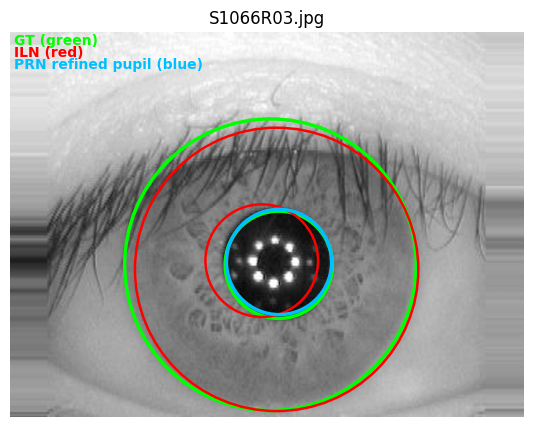

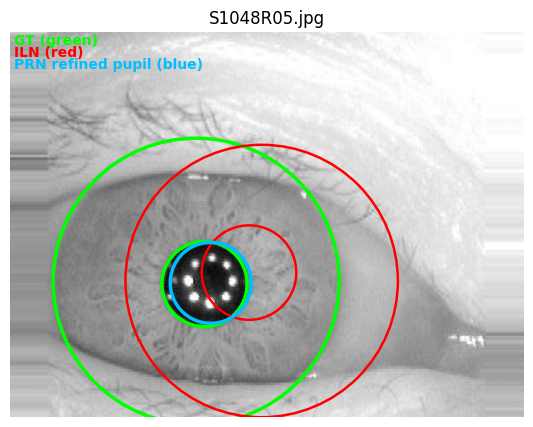

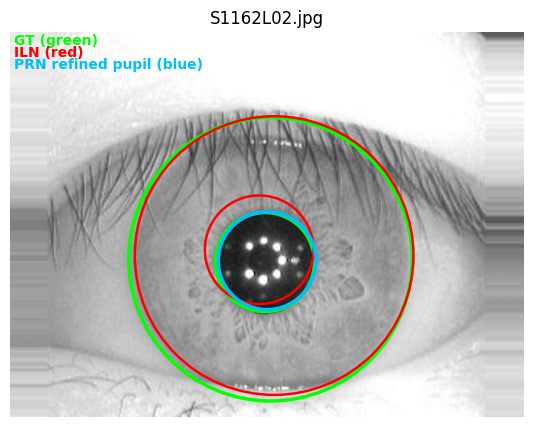

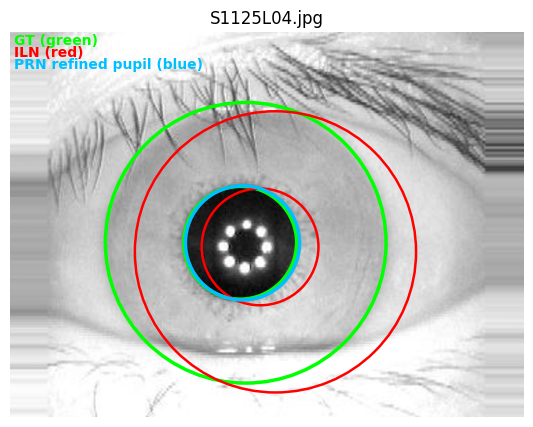

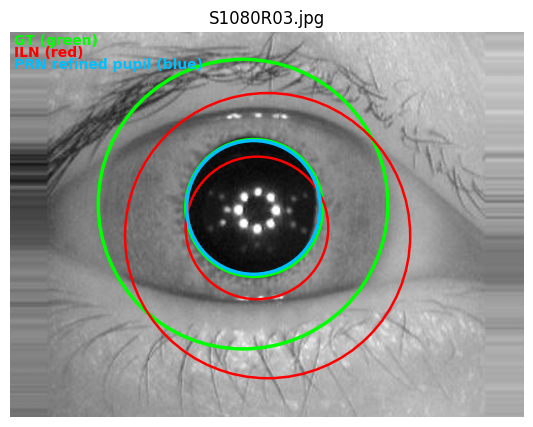

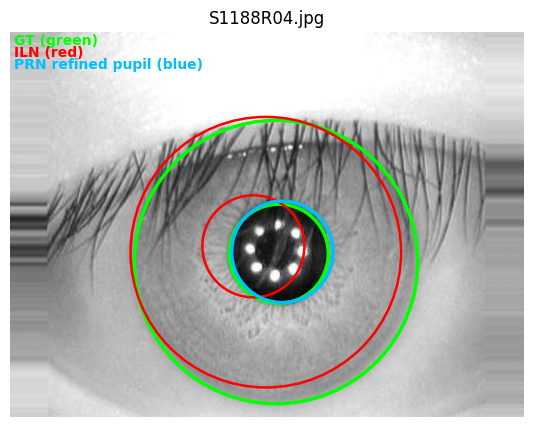

In [ ]:
# =========================
# CELL 16 — Full inference overlay (COLORED)
# GT = green | ILN = red | PRN refined pupil = blue
# =========================

import matplotlib.patches as patches

@torch.no_grad()
def prn_to_full(pupil_prn_norm, meta):
    x0, y0, x1, y1 = meta["roi_box_full"]
    sx = meta["scale_full_to_out"]  # 128 / roi_side_full

    xp_roi = float(pupil_prn_norm[0] * ROI_SIZE)
    yp_roi = float(pupil_prn_norm[1] * ROI_SIZE)
    rp_roi = float(pupil_prn_norm[2] * ROI_SIZE)

    xp_full = x0 + xp_roi / sx
    yp_full = y0 + yp_roi / sx
    rp_full = rp_roi / sx

    return xp_full, yp_full, rp_full


@torch.no_grad()
def show_full_pipeline_overlay_colored(model_iln, model_prn, loader, n_images=6, roi_scale=4.0):
    model_iln.eval()
    model_prn.eval()

    batch = next(iter(loader))
    x_full = batch["image"].to(device)   # (B,1,480,640)
    y_gt   = batch["y_iln"].to(device)   # (B,6)
    names  = batch["filename"]

    # --- ILN inference
    y_iln_hat = model_iln(x_full)

    # denormalize GT and ILN to full pixels
    y_gt_px  = denormalize_iln(y_gt).cpu().numpy()
    y_iln_px = denormalize_iln(y_iln_hat).cpu().numpy()

    x_np = x_full.cpu().numpy()

    B = x_np.shape[0]
    n_show = min(n_images, B)

    for i in range(n_show):
        img = x_np[i, 0]  # 480x640

        # GT full
        xp, yp, rp, xi, yi, ri = y_gt_px[i]

        # ILN full
        xpi, ypi, rpi, xii, yii, rii = y_iln_px[i]

        # --- build ROI centered on ILN pupil (inference-style)
        roi_img, _y_prn_dummy, meta = build_prn_sample(
            full_img_1x480x640=x_full[i].cpu(),
            pupil_px=(xpi, ypi, rpi),
            roi_center_px=(xpi, ypi),
            roi_scale=roi_scale,
            out_size=ROI_SIZE
        )

        # PRN inference on ROI
        roi_in = roi_img.unsqueeze(0).to(device)        # (1,1,128,128)
        y_prn_hat = model_prn(roi_in).squeeze(0).cpu()  # (3,)

        # map PRN pupil back to full frame
        xpr, ypr, rpr = prn_to_full(y_prn_hat, meta)

        # --- plot overlay
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.imshow(img, cmap="gray")
        ax.set_title(f"{names[i]}")
        ax.axis("off")

        # GT circles (GREEN)
        ax.add_patch(patches.Circle((xp, yp), rp, fill=False, linewidth=2.5, edgecolor="lime"))
        ax.add_patch(patches.Circle((xi, yi), ri, fill=False, linewidth=2.5, edgecolor="lime"))

        # ILN circles (RED)
        ax.add_patch(patches.Circle((xpi, ypi), rpi, fill=False, linewidth=1.8, edgecolor="red"))
        ax.add_patch(patches.Circle((xii, yii), rii, fill=False, linewidth=1.8, edgecolor="red"))

        # PRN refined pupil (BLUE)
        ax.add_patch(patches.Circle((xpr, ypr), rpr, fill=False, linewidth=2.5, edgecolor="deepskyblue"))

        # Legend (testo)
        ax.text(5, 15, "GT (green)", color="lime", fontsize=10, weight="bold")
        ax.text(5, 30, "ILN (red)", color="red", fontsize=10, weight="bold")
        ax.text(5, 45, "PRN refined pupil (blue)", color="deepskyblue", fontsize=10, weight="bold")

        plt.show()


# Run on validation
show_full_pipeline_overlay_colored(model_iln, model_prn, val_loader, n_images=6, roi_scale=4.0)
